In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
import talib
sns.set(style='darkgrid', context='talk', palette='Dark2')

my_year_month_fmt = mdates.DateFormatter('%m/%y')

year = '2019'
data = pd.read_csv('data/CME_DL_6AH' + str(int(year) + 1) + ', 1D.csv')
start_date = year + '-07-01'
end_date = str(int(year) + 1) + '-03-01'

In [2]:
data['datetime'] = pd.to_datetime(data['time'])
data = data.set_index('datetime')
data = pd.DataFrame(data.loc[:, 'open':'close'])
# testing range is 1 year for each contract
mask = (data.index >= start_date) & (data.index <= end_date)
data = data.loc[mask]
data.head()

,open,high,low,close
datetime,,,,
2019-07-01 22:00:00+00:00,0.7025,0.7034,0.7025,0.7034
2019-07-02 22:00:00+00:00,0.7064,0.7083,0.7064,0.7083
2019-07-04 22:00:00+00:00,0.7075,0.7075,0.7020,0.7027
2019-07-07 22:00:00+00:00,0.7017,0.7017,0.7017,0.7017
2019-07-08 22:00:00+00:00,0.6969,0.6975,0.6969,0.6975


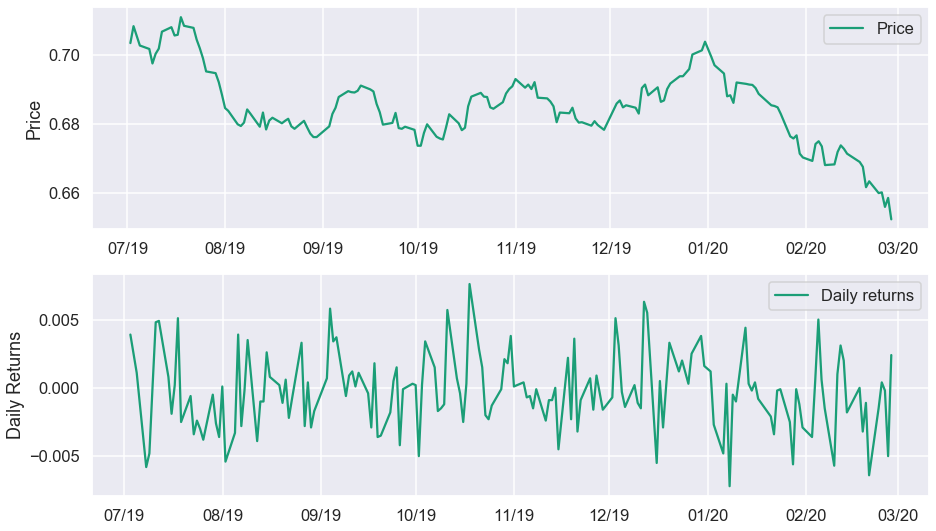

In [3]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,9))

ax1.plot(data.loc[start_date:end_date, :].index, data.loc[start_date:end_date, 'close'], label='Price')
ax1.set_ylabel('Price')
ax1.legend(loc='best')
ax1.xaxis.set_major_formatter(my_year_month_fmt)

ax2.plot(data.loc[start_date:end_date, :].index, data.loc[start_date:end_date, 'open'].diff(), label='Daily returns')
ax2.set_ylabel('Daily Returns')
ax2.legend(loc='best')
ax2.xaxis.set_major_formatter(my_year_month_fmt)

# volatility is cyclic

In [4]:
# ATR as a measure of volatility, to spot volatility changes
length = 4
num_range = 1.5
data['ATR'] = talib.ATR(data['high'], data['low'], data['close'], timeperiod=length)*num_range

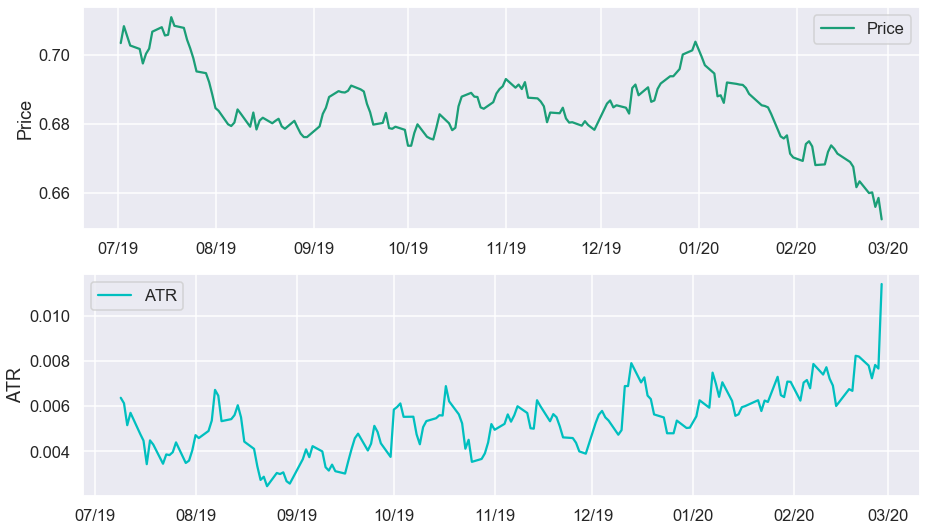

In [5]:
# Plot price and ATR
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,9))

ax1.plot(data.loc[start_date:end_date, :].index, data.loc[start_date:end_date, 'close'], label='Price')
ax1.set_ylabel('Price')
ax1.legend(loc='best')
ax1.xaxis.set_major_formatter(my_year_month_fmt)

ax2.plot(data.loc[start_date:end_date, :].index, data.loc[start_date:end_date, 'ATR'], label = 'ATR', color='c')
ax2.set_ylabel('ATR')
ax2.legend(loc='best')
ax2.xaxis.set_major_formatter(my_year_month_fmt)

In [6]:
# Set a buy stop order at Open + Average( Range, Length ) * NumRanges at next bar
# Set a sell stop order at Open - Average( Range, Length ) * NumRanges at next bar
data['long_stop']= data['open'] + data['ATR']
data['short_stop'] = data['open'] - data['ATR']

data['long_stop'] = data['long_stop'].shift(1)
data['short_stop'] = data['short_stop'].shift(1)
data.head(10)

,open,high,low,close,ATR,long_stop,short_stop
datetime,,,,,,,
2019-07-01 22:00:00+00:00,0.7025,0.7034,0.7025,0.7034,NaN,NaN,NaN
2019-07-02 22:00:00+00:00,0.7064,0.7083,0.7064,0.7083,NaN,NaN,NaN
2019-07-04 22:00:00+00:00,0.7075,0.7075,0.7020,0.7027,NaN,NaN,NaN
2019-07-07 22:00:00+00:00,0.7017,0.7017,0.7017,0.7017,NaN,NaN,NaN
2019-07-08 22:00:00+00:00,0.6969,0.6975,0.6969,0.6975,0.006375,NaN,NaN
2019-07-09 22:00:00+00:00,0.6970,0.7006,0.6970,0.7003,0.006131,0.703275,0.690525
2019-07-10 22:00:00+00:00,0.7018,0.7018,0.7018,0.7018,0.005161,0.703131,0.690869
2019-07-11 22:00:00+00:00,0.7067,0.7067,0.7067,0.7067,0.005708,0.706961,0.696639
2019-07-14 22:00:00+00:00,0.7075,0.7080,0.7075,0.7080,0.004769,0.712408,0.700992


In [7]:
data['trading_positions_long'] = data['high'] - data['long_stop']
data['trading_positions_short'] = data['low'] - data['short_stop']

data['trading_positions_long'] = data['trading_positions_long'].apply(np.sign)
data['trading_positions_short'] = data['trading_positions_short'].apply(np.sign)

# If no long/short signal, continue holding current position.
data['trading_positions'] = (data['trading_positions_long'] + data['trading_positions_short'])/2
for i in range(1, len(data)):
    if data.iloc[i, 9] == 0:
        data.iloc[i, 9] = data.iloc[i-1, 9]
data.head(20)

,open,high,low,close,ATR,long_stop,short_stop,trading_positions_long,trading_positions_short,trading_positions
datetime,,,,,,,,,,
2019-07-01 22:00:00+00:00,0.7025,0.7034,0.7025,0.7034,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-02 22:00:00+00:00,0.7064,0.7083,0.7064,0.7083,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-04 22:00:00+00:00,0.7075,0.7075,0.7020,0.7027,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-07 22:00:00+00:00,0.7017,0.7017,0.7017,0.7017,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-08 22:00:00+00:00,0.6969,0.6975,0.6969,0.6975,0.006375,NaN,NaN,NaN,NaN,NaN
2019-07-09 22:00:00+00:00,0.6970,0.7006,0.6970,0.7003,0.006131,0.703275,0.690525,-1.0,1.0,NaN
2019-07-10 22:00:00+00:00,0.7018,0.7018,0.7018,0.7018,0.005161,0.703131,0.690869,-1.0,1.0,NaN
2019-07-11 22:00:00+00:00,0.7067,0.7067,0.7067,0.7067,0.005708,0.706961,0.696639,-1.0,1.0,NaN
2019-07-14 22:00:00+00:00,0.7075,0.7080,0.7075,0.7080,0.004769,0.712408,0.700992,-1.0,1.0,NaN


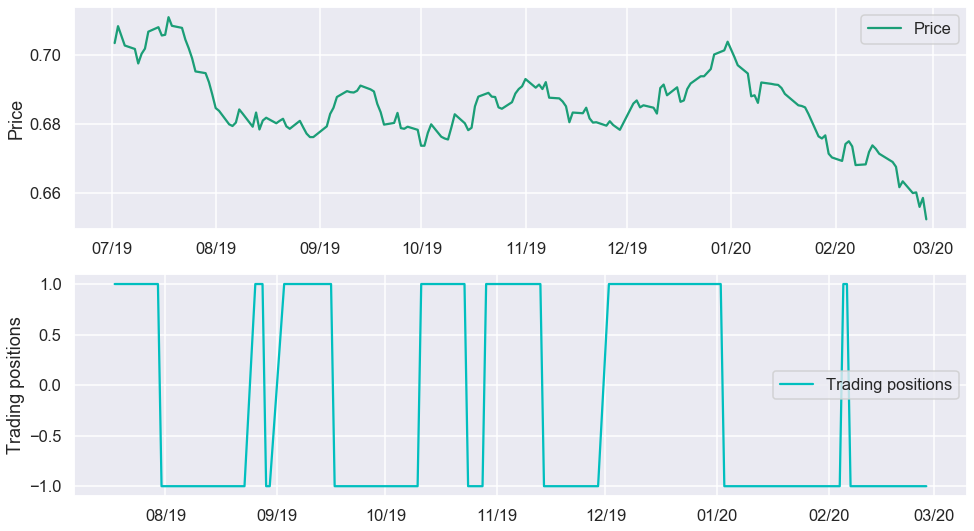

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))

ax1.plot(data.loc[start_date:end_date, :].index, data.loc[start_date:end_date, 'close'], label='Price')
ax1.set_ylabel('Price')
ax1.legend(loc='best')
ax1.xaxis.set_major_formatter(my_year_month_fmt)

ax2.plot(data.loc[start_date:end_date, :].index, data.loc[start_date:end_date, 'trading_positions'], label='Trading positions', color='c')
ax2.set_ylabel('Trading positions')
ax2.legend(loc='best')
ax2.xaxis.set_major_formatter(my_year_month_fmt)

Total portfolio return is: -7.25%
Average yearly return is: -10.74%
Total portfolio return is:  4.20%
Average yearly return is:  6.44%


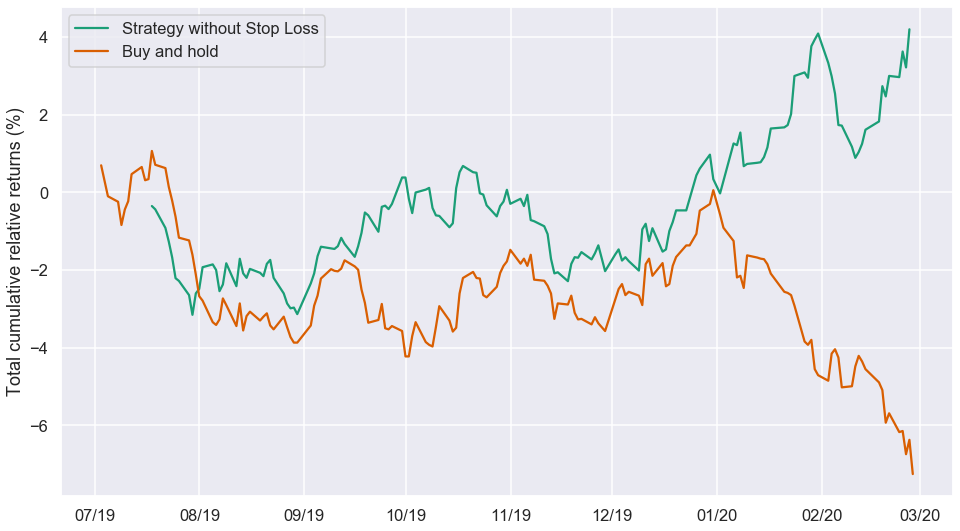

In [9]:
# Obtain order cost 
# Assume no slippage
data['order_price'] = data['close']
for i in range(1, len(data)):
    if data['trading_positions'][i] != data['trading_positions'][i - 1]: # order executed
        if data['trading_positions'][i] == 1: # long entry
            data['order_price'][i] = data['long_stop'][i] if data['long_stop'][i] >= data['open'][i] else data['open'][i]
        if data['trading_positions'][i] == -1: # short entry
            data['order_price'][i] = data['short_stop'][i] if data['short_stop'][i] <= data['open'][i] else data['open'][i]
          
        
## 
## Calculate cumulative returns of the strategy
strategy_asset_log_returns = np.log(data['order_price']).diff()
strategy_asset_log_returns = data['trading_positions'] * strategy_asset_log_returns.shift(-1)
cum_strategy_asset_log_returns = strategy_asset_log_returns.cumsum()
# Transform the cumulative log returns to relative returns
cum_strategy_asset_relative_returns_nostop = np.exp(cum_strategy_asset_log_returns) - 1

##
## Calculate cumulative returns of buy and hold
asset_log_returns = np.log(data['close']).diff()
simple_cum_strategy_asset_log_returns = asset_log_returns.cumsum()
# Transform the cumulative log returns to relative returns
simple_cum_strategy_asset_relative_returns = np.exp(simple_cum_strategy_asset_log_returns) - 1


def print_portfolio_yearly_statistics(portfolio_cumulative_relative_returns, days_per_year = 252):

    total_days_in_simulation = portfolio_cumulative_relative_returns.shape[0]
    number_of_years = total_days_in_simulation / days_per_year

    # The last data point will give us the total portfolio return
    total_portfolio_return = portfolio_cumulative_relative_returns.values[-1]
    # Average portfolio return assuming compunding of returns
    average_yearly_return = (1 + total_portfolio_return)**(1/number_of_years) - 1

    print('Total portfolio return is: ' + '{:5.2f}'.format(100*total_portfolio_return) + '%')
    print('Average yearly return is: ' + '{:5.2f}'.format(100*average_yearly_return) + '%')

print_portfolio_yearly_statistics(simple_cum_strategy_asset_relative_returns)


fig, ax = plt.subplots(figsize=(16,9))

ax.plot(cum_strategy_asset_relative_returns_nostop.index, 100*cum_strategy_asset_relative_returns_nostop, label='Strategy without Stop Loss')
ax.plot(simple_cum_strategy_asset_relative_returns.index, 100*simple_cum_strategy_asset_relative_returns, label='Buy and hold')

ax.set_ylabel('Total cumulative relative returns (%)')
ax.legend(loc='best')
ax.xaxis.set_major_formatter(my_year_month_fmt)

print_portfolio_yearly_statistics(cum_strategy_asset_relative_returns_nostop[:-1])

In [10]:
# Set stop loss order
entry_point = data.iloc[0]
loss_multiplier = 0.45

for i in range(1, len(data)):
    if data['trading_positions'][i] != data['trading_positions'][i - 1]: # new order executed
        entry_point = data.iloc[i] # update the entry point to current order
    long_exit = (entry_point['order_price'] - loss_multiplier * data['ATR'][-1]) # exit point for long entry
    short_exit = (entry_point['order_price'] + loss_multiplier * data['ATR'][-1]) # exit point for short entry
    if data['trading_positions'][i] == 1 and data['low'][i] < long_exit: # if holding long position, check long exit point
        data['trading_positions'][i] = 0 # close current position
        data['order_price'][i] = long_exit if data['open'][i] > long_exit else data['open'][i]
    if data['trading_positions'][i] == -1 and data['high'][i] > short_exit: # if holding short position, check short exit point
        data['trading_positions'][i] = 0 # close current position
        data['order_price'][i] = short_exit if data['open'][i] < short_exit else data['open'][i]
        

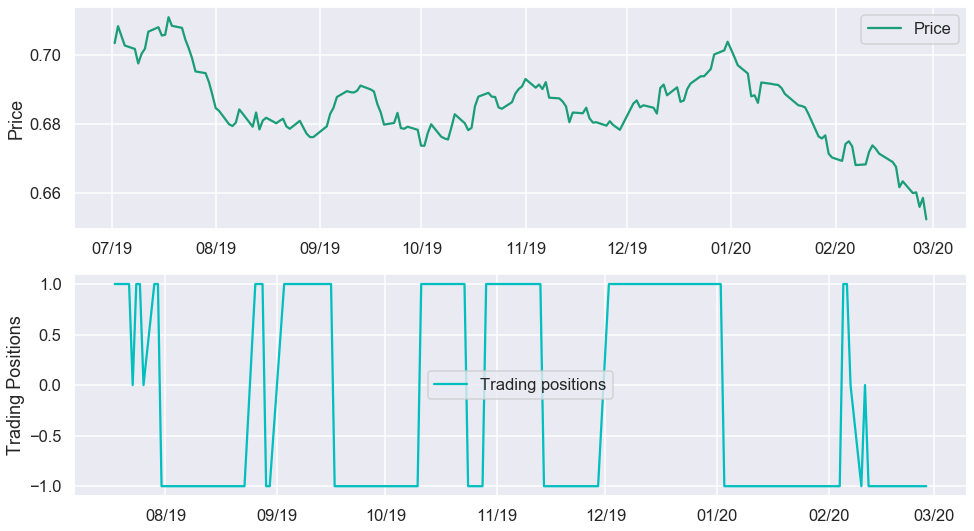

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,9))

ax1.plot(data.loc[start_date:end_date, :].index, data.loc[start_date:end_date, 'close'], label='Price')
ax1.set_ylabel('Price')
ax1.legend(loc='best')
ax1.xaxis.set_major_formatter(my_year_month_fmt)

ax2.plot(data.loc[start_date:end_date, :].index, data.loc[start_date:end_date, 'trading_positions'], label='Trading positions', color='c')
ax2.set_ylabel('Trading Positions')
ax2.legend(loc='best')
ax2.xaxis.set_major_formatter(my_year_month_fmt)

In [12]:
#
## Calculate cumulative returns of the strategy with stop loss orders
strategy_asset_log_returns = np.log(data['order_price']).diff()
strategy_asset_log_returns = data['trading_positions'] * strategy_asset_log_returns.shift(-1)
cum_strategy_asset_log_returns = strategy_asset_log_returns.cumsum()

# Transform the cumulative log returns to relative returns
cum_strategy_asset_relative_returns = np.exp(cum_strategy_asset_log_returns) - 1

print_portfolio_yearly_statistics(cum_strategy_asset_relative_returns[:-1])


Total portfolio return is:  5.55%
Average yearly return is:  8.54%


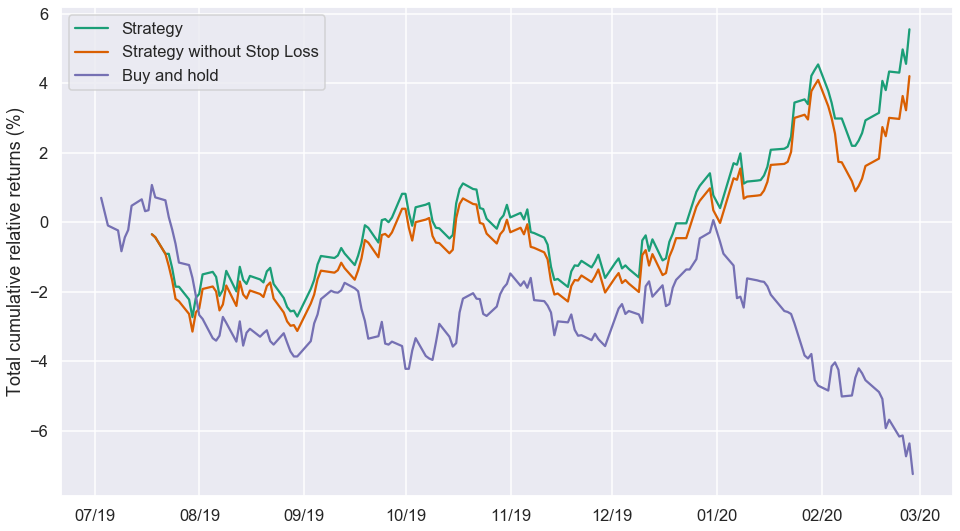

In [13]:
# Compare strategy returns with buy and hold 
fig, ax = plt.subplots(figsize=(16,9))

ax.plot(cum_strategy_asset_relative_returns.index, 100*cum_strategy_asset_relative_returns, label='Strategy')
ax.plot(cum_strategy_asset_relative_returns.index, 100*cum_strategy_asset_relative_returns_nostop, label='Strategy without Stop Loss')
ax.plot(simple_cum_strategy_asset_relative_returns.index, 100*simple_cum_strategy_asset_relative_returns, label='Buy and hold')

ax.set_ylabel('Total cumulative relative returns (%)')
ax.legend(loc='best')
ax.xaxis.set_major_formatter(my_year_month_fmt)

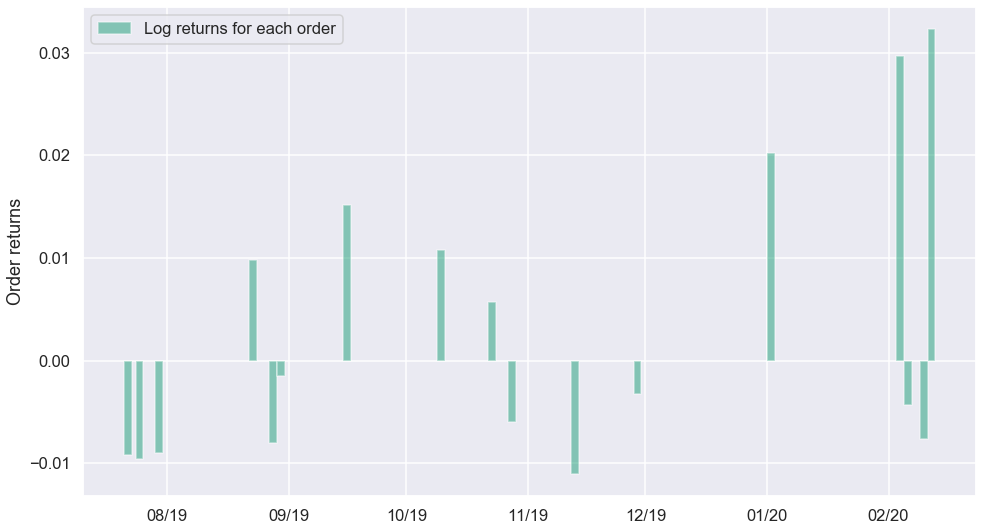

In [14]:
# Order statistics
# get all the trades
trades= data.iloc[[0]]
trades = trades.dropna()

for i in range(1, len(data)):
    if data['trading_positions'][i] != data['trading_positions'][i - 1]: # if new order executed
        if data.iloc[[i - 1]].index not in trades.index:  
            trades = trades.append(data.iloc[[i - 1]])
        trades = trades.append(data.iloc[[i]]) # append new order to trades
    if i == len(data) - 1:
        trades = trades.append(data.iloc[[i]]) # any open trade is closed on the last day of testing period
trades = trades.dropna()

trades['log_returns'] = np.log(trades['order_price']).diff().shift(-1)
trades['cum_log_returns'] = np.nan

# Calculate the log returns for each trade
for i in range(1, len(trades)):
    if (trades['trading_positions'][i] == trades['trading_positions'][i - 1]):
        trades['cum_log_returns'][i] = trades['log_returns'][i] + trades['log_returns'][i - 1]
    if i == (len(trades)- 2) and trades['trading_positions'][i]:
        trades['cum_log_returns'][i] = trades['log_returns'][i] # assume last trade is closed at the end of testing period
trades_closed = trades.dropna()
trades_closed = trades_closed[trades_closed['trading_positions'] != 0]
trades_closed['cum_log_returns_true'] = trades_closed['cum_log_returns'] *trades_closed['trading_positions']

# Plot log reuturns for each executed order
fig, ax = plt.subplots(figsize=(16,9))

ax.bar(trades_closed.index, trades_closed['cum_log_returns_true'], 2, label='Log returns for each order', alpha=0.5)
ax.set_ylabel('Order returns')
ax.legend(loc='best')
ax.xaxis.set_major_formatter(my_year_month_fmt)

In [15]:
# average holding period
num_longs = trades_closed['trading_positions'].value_counts()[1]
num_shorts = trades_closed['trading_positions'].value_counts()[-1]
print('Total # of Longs: ', num_longs)
print('Total # of Shorts: ', num_shorts)
print('Total # of trades: ', num_longs + num_shorts)
print('Averaege Holing Period: ', 252 / (num_longs + num_shorts))

Total # of Longs:  9
Total # of Shorts:  8
Total # of trades:  17
Averaege Holing Period:  14.823529411764707


In [16]:
# max/min gain/loss of each trade
trades_closed['percent_returns'] = (np.exp(trades_closed['cum_log_returns_true']) - 1) * 100
print('Largest Win Trade: ' + '{:5.2f}'.format(trades_closed['percent_returns'].values.max()) + '%')
print('Largest Losing Trade: ' + '{:5.2f}'.format(trades_closed['percent_returns'].values.min()) + '%')

Largest Win Trade:  3.28%
Largest Losing Trade: -1.10%


In [17]:
# Sharpe ratio calculation
# buy and hold
bh_returns = data['close'].diff()
bh_sr = bh_returns.mean()/bh_returns.std() * np.sqrt(252)

strategy_returns = data['trading_positions'] * data['order_price'].diff().shift(-1)
strategy_sr = strategy_returns.mean()/strategy_returns.std() * np.sqrt(252)
print('Buy and Hold Sharpe Ratio: ' + '{:5.2f}'.format(bh_sr))
print('Streategy Sharpe Ratio: ' + '{:5.2f}'.format(strategy_sr))

Buy and Hold Sharpe Ratio: -1.76
Streategy Sharpe Ratio:  1.38
